# $\text{UF}_{3}$: $\text{BaTiO}_3$

Esta notebook se hizo a manera de ejemplo de como usar la librería $\text{UF}_3$ para ajustar potenciales efectivos de interacción de dos cuerpos en una base de B-splines. En este caso el material a similar es el titanato de bario ($\text{BaTiO}_3$). Todo esto se hizo en el marco de la tesina de grado de la Licencitura en Física de Andrés Alasia: **subir pdf**

Los datos de ajuste son posiciones de átomos y fuerzas actuantes sobre los mismo pertenecientes a 1458 estructuras de $\text{BaTiO}_3$. Estas estructuras son representativas de las 4 fases observadas experimentalmente del material. La base de datos es de dominio público. Para más detalle ver **subir pdf**

Antes de correr esta notebook leer el archivo ```README.md``` en la raíz del repositorio.

La documentación del paquete $\text{UF}_3$ se encuentra disponible en el siguiente link: [Documentación](https://uf3.readthedocs.io/en/latest/index.html)

**Datos**
- Conjunto de entrenamiento: 1020 estructuras (selección aleatoria del 70% de las estructuras en cada una de las fases del material)

- Conjunto de evaluación: 438 configuraciones (el 30% restante de las estructuras)

**Inputs**
- ```Training_set.xyz``` (6.13 mb)
- ```training_idx_70%.txt``` (6 kb, incluido con el fin de garantizar la reproducibilidad)

**Outputs**
- ```model_2.json``` (12 kb)
- ```BTO.table``` (192 kb)

## Importación de paquetes necesarios

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

In [48]:
from uf3.data import io
from uf3.data import composition
from uf3.representation import bspline
from uf3.representation import process
from uf3.regression import least_squares
from uf3.forcefield import calculator
from uf3.forcefield import lammps
from uf3.util import plotting
from uf3.forcefield.properties import phonon

In [49]:
from src.utils import DATA_IN_PATH, DATA_OUT_PATH # Rutas a los archivos de entrada y de salida

## Definición de parámetros

```element_list (list)```: lista de elementos del compuesto.

```degree (int)```: grado en el cual se trunca la expansión de muchos cuerpos del potencial.
 Un valor de 2 implica un potencial de pares.

In [50]:
element_list = ['Ti', 'Ba', 'O']
degree = 2

Inicializar ```chemical_system``` (objeto que representa el sistema químico) y ver interacciones.

Los elementos involucrados en cada interacción son ordenados por su electronegatividad.

In [51]:
chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)
print(chemical_system)

ChemicalSystem:
    Elements: ('Ti', 'O', 'Ba')
    Degree: 2
    Pairs: [('O', 'O'), ('O', 'Ti'), ('O', 'Ba'), ('Ti', 'Ti'), ('Ti', 'Ba'), ('Ba', 'Ba')]


```r_min_map (dict)```: mapa de la distancia miníma entre pares en cada interacción (angstroms). 
    Valor por default: 1.0 para todas las interacciones.
    
```r_max_map (dict)```: mapa de la distancia máxima entre pares en cada interacción (angstroms). 
    Valor por default: 6.0 para todas las interacciones, valor con el cual probablemente se alcancen por lo menos segundos vecinos.
    
```resolution_map (dict)```: mapa de resolución (número de intérvalos de nodos) para todas las interacciones.
    Para la base cúbica, el número de funciones de la base es el número de intérvalos más 3.
    Esto no es cierto si añadimos ```trailing_trim``` (ver a continuación).
    El valor por default es 20.
    
```trailing_trim (int)```: numero de funciones base traseras a recortar, el valor por default es 3.
 - ```= 0```: corte de la función en ```r_max```
 - ```= 1```: la función va a 0 en ```r_max```
 - ```= 2```: la primera derivada va a 0 en ```r_max```
 - ```= 3```: la segunda derivada va a 0 en ```r_max```
 
```leading_trim (int)```: similar para funciones base delanteras (pequeñas distancias).

In [52]:
r_min_map = {("O", "O"): 0.001,
             ("O", "Ti"): 0.001,
             ("O", "Ba"): 0.001,
             ("Ba", "Ba"): 0.001,
             ("Ba", "Ti"): 0.001,
             ("Ti", "Ti"): 0.001,
            }
r_max_map = {("O", "O"): 4.42,
             ("O", "Ti"): 5.12,
             ("O", "Ba"): 5.235,
             ("Ba", "Ba"): 6.335,
             ("Ba", "Ti"): 4.07,
             ("Ti", "Ti"): 6.29,
            }
resolution_map = {("O", "O"): 24,
                  ("O", "Ti"): 24,
                  ("O", "Ba"): 24,
                  ("Ba", "Ba"): 24,
                  ("Ba", "Ti"): 24,
                  ("Ti", "Ti"): 24,
                 }
trailing_trim = 3
leading_trim = 0

```n_cores (int)```: número de trabajadores que van a ser usados para la generación de características (features).

```data_filename (pathlib.WindowsPath)```: nombre del archivo de referencia que contiene geometrías, energías, fuerzas, ...

```training_set (list)```: lista de enteros correspondientes a las entradas usadas para la fase de training.

In [53]:
n_cores = 4

In [54]:
data_filename = DATA_IN_PATH / "Training_set.xyz"
with open((DATA_IN_PATH / "training_idx_70%.txt"), "r") as f:
    training_set = [int(idx) for idx in f.read().splitlines()]

# Inicializar y mostrar características de la base

Inicializar ```bspline_config``` (objeto que representa la base de B-splines) y ver las características de la base.

In [55]:
bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      leading_trim=leading_trim,
                                      trailing_trim=trailing_trim)

print(bspline_config)

BSplineBasis:
    Basis functions:
        ('O', 'O'): 27
        ('O', 'Ti'): 27
        ('O', 'Ba'): 27
        ('Ti', 'Ti'): 27
        ('Ti', 'Ba'): 27
        ('Ba', 'Ba'): 27
ChemicalSystem:
    Elements: ('Ti', 'O', 'Ba')
    Degree: 2
    Pairs: [('O', 'O'), ('O', 'Ti'), ('O', 'Ba'), ('Ti', 'Ti'), ('Ti', 'Ba'), ('Ba', 'Ba')]


# Cargar datos

Inicializar ```data_cordinator``` (objeto para leer datos desde códigos atomísticos y organizarla en DataFrames de Pandas).

In [56]:
data_coordinator = io.DataCoordinator()
data_coordinator.dataframe_from_trajectory(str(data_filename),
                                           prefix='dft')
df_data = data_coordinator.consolidate()
print("Número de energías:", len(df_data))
print("Número de fuerzas:", int(np.sum(df_data["size"]) * 3))

Número de energías: 1458
Número de fuerzas: 174960


### Visualización de los datos 

In [57]:
# Obtención de los datos como listas usando los métodos del objeto ase.Atoms que se encuentra en la columna 'geometry'
import pandas as pd
df_view = pd.DataFrame()
df_view['positions'] = list(map(lambda est: est.get_positions(),df_data['geometry']))
df_view['kinds'] = list(map(lambda est: est.get_chemical_symbols(),df_data['geometry']))
df_view['cell'] = list(map(lambda est: np.array(est.get_cell()),df_data['geometry']))
df_view['vol'] = list(map(lambda est: est.get_volume(),df_data['geometry']))
df_view['angles'] = list(map(lambda est: est.get_cell().angles(),df_data['geometry']))
df_view.head()

,positions,kinds,cell,vol,angles
0,"[[3.88500985, 3.95920046, 7.79670528], [4.0658...","[Ba, Ba, Ba, Ba, Ba, Ba, Ba, Ba, Ti, Ti, Ti, T...","[[7.955160132292204, 0.0, 0.0], [0.0, 7.955160...",503.438910,"[90.0, 90.0, 90.0]"
1,"[[3.91771984, 3.7925496, 0.04084469], [7.93743...","[Ba, Ba, Ba, Ba, Ba, Ba, Ba, Ba, Ti, Ti, Ti, T...","[[7.954639951096393, 0.0, 0.0], [0.0, 7.954639...",503.340158,"[90.0, 90.0, 90.0]"
2,"[[3.94192967, 3.96752982, 3.8377903], [3.96893...","[Ba, Ba, Ba, Ba, Ba, Ba, Ba, Ba, Ti, Ti, Ti, T...","[[7.979600181660014, 0.0, 0.0], [0.0, 7.979600...",508.093214,"[90.0, 90.0, 90.0]"
3,"[[2.04999962, 1.90644026, 1.85373021], [5.9937...","[Ba, Ba, Ba, Ba, Ba, Ba, Ba, Ba, Ti, Ti, Ti, T...","[[8.00504990114136, 0.0, 0.0], [0.0, 8.0050499...",512.970193,"[90.0, 90.0, 90.0]"
4,"[[3.84626, 3.81199009, 4.04678973], [4.0249799...","[Ba, Ba, Ba, Ba, Ba, Ba, Ba, Ba, Ti, Ti, Ti, T...","[[7.955129969191328, 0.0, 0.0], [0.0, 7.955129...",503.433183,"[90.0, 90.0, 90.0]"


In [58]:
a = list(map(lambda arr: arr[0][0]/2, df_view['cell']))
b = list(map(lambda arr: arr[1][1]/2, df_view['cell']))
c = list(map(lambda arr: arr[2][2]/2, df_view['cell']))

In [59]:
alpha = list(map(lambda arr: arr[0] if arr[0]<=90 else 180-arr[0], df_view['angles']))
beta = list(map(lambda arr: arr[1] if arr[1]<=90 else 180-arr[1], df_view['angles']))
gamma = list(map(lambda arr: arr[2] if arr[2]<=90 else 180-arr[2], df_view['angles']))

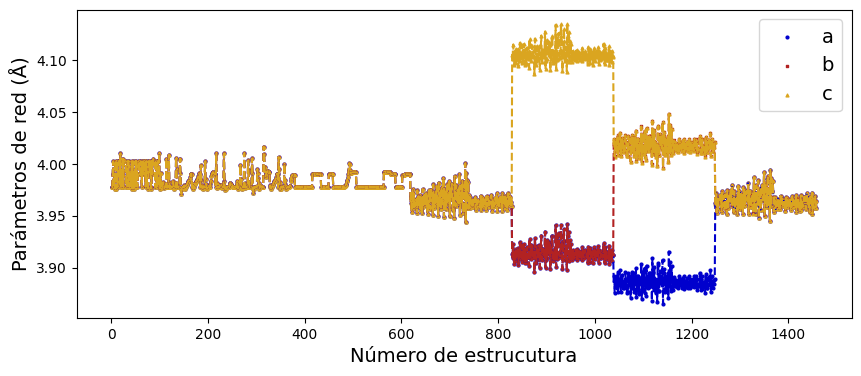

In [60]:
# Parámetros macrocelda
plt.figure(figsize=(10, 4))
plt.scatter(range(1,len(a)+1),a,label='a',marker='o', s=4, c='mediumblue')
plt.plot(range(1,len(a)+1),a,linestyle='dashed', c='mediumblue')
plt.scatter(range(1,len(a)+1),b,label='b',marker='s', s=4, c='firebrick')
plt.plot(range(1,len(a)+1),b,linestyle='dashed', c='firebrick')
plt.scatter(range(1,len(a)+1),c,label='c',marker='^', s=4, c='goldenrod')
plt.plot(range(1,len(a)+1),c,linestyle='dashed', c='goldenrod')
plt.xlabel('Número de estrucutura',fontsize=14)
plt.ylabel('Parámetros de red (\u212B)',fontsize=14)
plt.legend(fontsize=14)
plt.show()

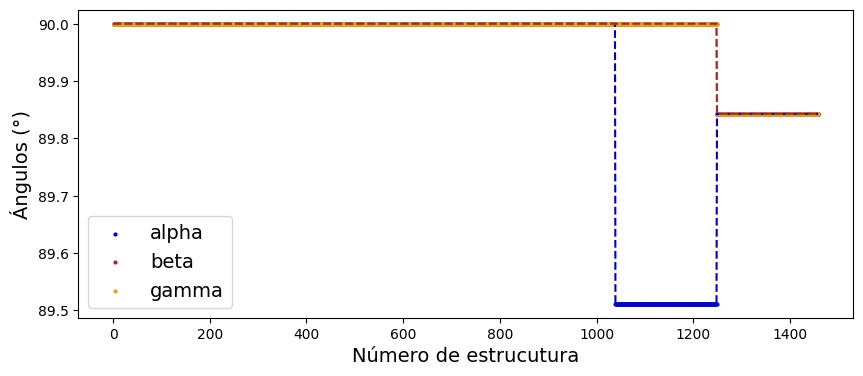

In [61]:
# Parámetros macrocelda
plt.figure(figsize=(10, 4))
plt.scatter(range(1,len(alpha)+1),alpha,label='alpha',marker='o', s=4, c='mediumblue')
plt.plot(range(1,len(alpha)+1),alpha,linestyle='dashed', c='mediumblue')
plt.plot(range(1,len(beta)+1),gamma,linestyle='dashed', c='goldenrod')
plt.scatter(range(1,len(beta)+1),beta,label='beta',marker='o', s=4, c='firebrick')
plt.plot(range(1,len(beta)+1),beta,linestyle='dashed', c='firebrick')
plt.scatter(range(1,len(beta)+1),gamma,label='gamma',marker='o', s=4, c='goldenrod')
plt.xlabel('Número de estrucutura',fontsize=14)
plt.ylabel('Ángulos (°)',fontsize=14)
plt.legend(fontsize=14)
plt.show()

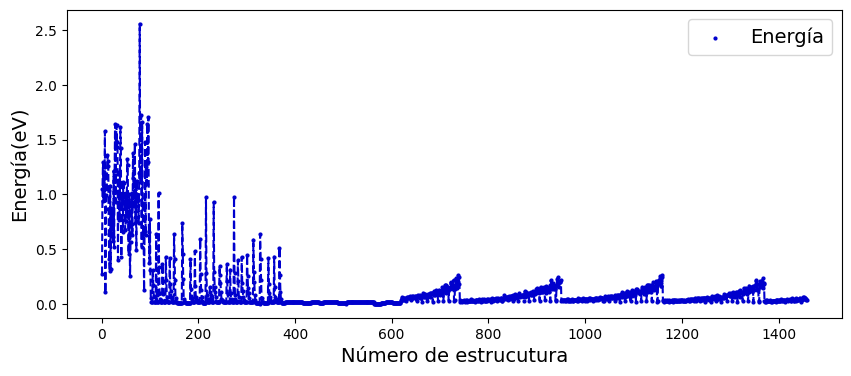

In [62]:
# Parámetros macrocelda
plt.figure(figsize=(10, 4))
plt.scatter(range(1,len(df_data['energy'])+1),(df_data['energy']-df_data['energy'].min())/8,label='Energía',marker='o', s=4, c='mediumblue')
plt.plot(range(1,len(df_data['energy'])+1),(df_data['energy']-df_data['energy'].min())/8,linestyle='dashed', c='mediumblue')
plt.xlabel('Número de estrucutura',fontsize=14)
plt.ylabel('Energía(eV)',fontsize=14)
plt.legend(fontsize=14)
plt.show()

Se muestran las primeras 5 entradas del DataFrame que contiene la información de las estructuras.

In [63]:
df_data.head()

,geometry,energy,fx,fy,fz,size
dft_0,"(Atom('Ba', [3.88500985, 3.95920046, 7.7967052...",-29613.169688,"[0.1011328, -0.61998322, 0.16914131, 0.4578304...","[-0.21544173, -0.15334471, -0.04087231, 0.6974...","[1.08193409, -0.99224373, 0.49868551, -0.44923...",40.0
dft_1,"(Atom('Ba', [3.91771984, 3.7925496, 0.04084469...",-29606.964595,"[-0.04985678, 1.09645543, 1.47191465, -0.70881...","[0.12524589, 1.04541852, 1.1688109, -0.7010853...","[1.37775571, -0.09029123, -0.43401224, -0.2789...",40.0
dft_2,"(Atom('Ba', [3.94192967, 3.96752982, 3.8377903...",-29604.984526,"[0.11262949, -0.36125876, 0.56573551, -0.48344...","[0.73865197, 0.16037796, 0.27290717, -0.484911...","[0.23704877, -0.15182827, 1.33928069, -0.66627...",40.0
dft_3,"(Atom('Ba', [2.04999962, 1.90644026, 1.8537302...",-29607.846792,"[0.78364885, -0.62736408, -0.81859605, -1.2033...","[-0.01387342, 0.51993182, -2.85851599, -0.1524...","[0.6513044, 1.32673294, -0.32182807, -0.879217...",40.0
dft_4,"(Atom('Ba', [3.84626, 3.81199009, 4.04678973],...",-29605.736387,"[2.88644562, -2.66614785, -2.1459458, 0.724143...","[1.10727514, -0.55729998, -0.27156917, 0.50631...","[-2.06563354, -4.72607122, 0.90782387, 1.41830...",40.0


# Examinar distribución de distnacia de pares
Paso útil para chequear radios de corte de cada interacción así como también su resolución.

In [64]:
from uf3.data import analyze

Se inicializa ```analyzer```, objeto usado para el análisis de las distancia de pares.

In [65]:
analyzer = analyze.DataAnalyzer(chemical_system, 
                                r_cut=10,
                                bins=0.01)

In [66]:
atoms_key = data_coordinator.atoms_key
analyzer.load_entries(df_data[atoms_key])

100%|██████████| 1458/1458 [01:00<00:00, 24.03it/s]


Se da infromación útil para determinar o chequear los posibles radios de corte para el potencial (```r_min_map``` y ```r_max_map```), esta información se imprime por pantalla. 

In [67]:
analysis = analyzer.analyze(smooth=True,
                            filter_width=101,
                            filter_degree=3)

    Smallest observed: 2.34 angstroms
    Suggested Cutoffs: [3.685 4.425 5.245 5.715 6.05  6.55  6.825 6.845 7.14  7.435 7.455 7.48
 7.915 8.375 8.535 8.86  9.185 9.51 ]
    Smallest observed: 1.28 angstroms
    Suggested Cutoffs: [3.015 3.2   3.25  3.285 3.355 3.455 3.515 3.555 3.595 3.775 4.19  4.775
 5.18  5.35  5.705 6.245 6.565 6.63  6.91  7.425 7.94  8.655]
    Smallest observed: 2.04 angstroms
    Suggested Cutoffs: [3.28  3.79  3.85  3.875 4.38  5.235 5.94  6.55  7.125 7.935 8.88 ]
    Smallest observed: 3.51 angstroms
    Suggested Cutoffs: [3.2   3.635 4.32  4.68  4.705 4.755 4.82  4.87  5.015 5.38  5.94  6.29
 6.365 6.645 7.155 7.435 7.455 7.71  8.425 9.32 ]
    Smallest observed: 2.65 angstroms
    Suggested Cutoffs: [2.28  2.32  2.345 2.365 2.4   2.435 2.475 2.515 2.985 3.69  4.095 4.305
 4.39  4.445 4.485 4.53  4.57  4.605 4.775 5.115 5.325 5.37  5.47  5.555
 5.625 5.71  5.755 6.185 6.835 7.175 7.355 7.475 7.55  7.625 7.675 7.705
 7.735 8.205 9.06 ]
    Smallest observed

Se presenta la misma información que antes en forma de histogramas.

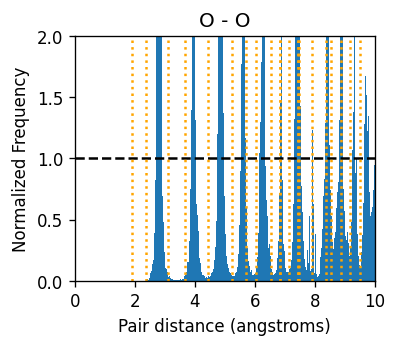

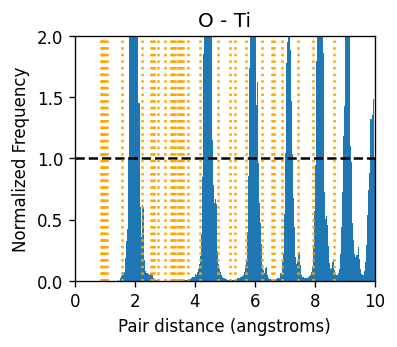

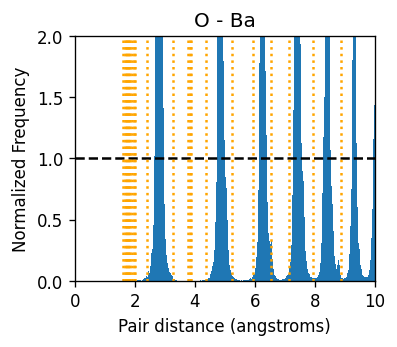

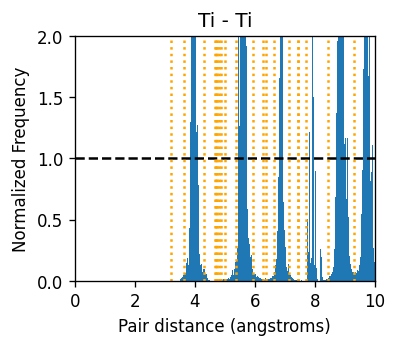

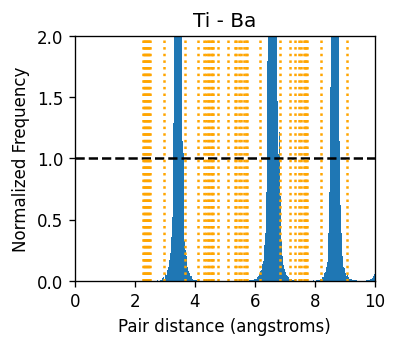

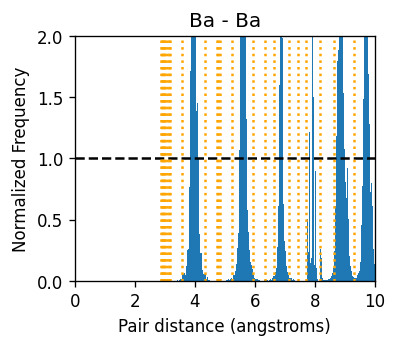

In [68]:
canvases = plotting.plot_pair_distributions(analysis, show_cutoffs=True)
for fig, ax in canvases:
    fig.set_dpi(120)
    fig.tight_layout()

# Calcular características de energía y fuerza 

Se calculan las características para el entrenamiento, se construye un DataFrame nuevo.

Las columnas nombradas de la forma $\text{E}_j\text{E}_{j'}i$, siendo $\text{E}_j$ el elemento $j$ en ```elment_list```, contienen información relacionada con las entradas de la matriz $\textbf{X}$ (ver documento **pdf**), faltan los prefactores relacionados con la dispersión en el set de datos de la magnitud de la energía y las componentes de fuerza ($\frac{\sqrt{\kappa}}{\sigma_{\mathcal{E}}}$ y $\frac{\sqrt{1-\kappa}}{\sigma_{\mathcal{F}}}$).

La columna y contiene información sobre los valores de energía y los valores de componentes de fuerza de cada estructura y está relacionada con el vector $y$ (ver documento **pdf**), al igual que antes faltan los prefactores.

Las columnas nombradas de la forma $\text{n}\_\text{E}_j$ contienen el número de átomos de cada especie en cada estructura.

In [69]:
representation = process.BasisFeaturizer(bspline_config)

In [70]:
client = ProcessPoolExecutor(max_workers=n_cores)

In [71]:
n_batches = n_cores * 16  # granularidad añadida para más actualizaciones de la barra de progreso
df_features = representation.evaluate_parallel(df_data,
                                               client,
                                               energy_key=data_coordinator.energy_key,
                                               n_jobs=n_batches)

  0%|          | 0/64 [00:00<?, ?it/s]

100%|██████████| 64/64 [02:03<00:00,  1.93s/it]


In [72]:
df_features.shape

(176418, 166)

In [73]:
df_features.head()

y  n_Ti   n_O  n_Ba  OO0  OO1  OO2  OO3  OO4  OO5  \
dft_0 energy -29613.169688   8.0  24.0   8.0  0.0  0.0  0.0  0.0  0.0  0.0   
      fx_0        0.101133   0.0   0.0   0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0   
      fx_1       -0.619983   0.0   0.0   0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0   
      fx_2        0.169141   0.0   0.0   0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0   
      fx_3        0.457830   0.0   0.0   0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0   

              ...     BaBa17    BaBa18  BaBa19    BaBa20     BaBa21  \
dft_0 energy  ...  11.786585  0.600512     0.0  0.139397  10.105180   
      fx_0    ...   3.405922  0.985340    -0.0  0.083274   7.073931   
      fx_1    ...  -2.870929 -1.761380    -0.0  0.000019  -5.428389   
      fx_2    ...   2.396881  0.362375    -0.0 -0.021079   1.239261   
      fx_3    ...   3.004262  1.770955    -0.0  0.428195   6.811730   

                 BaBa22     BaBa23  BaBa24  BaBa25  BaBa26  
dft_0 energy  48.104864  34.393438     0.0     0.0     0.0  
      fx_0   -11.704956   0.334637    -0.0    -0.0    -0.0  
      fx_1     9.041064  -0.414496    -0.0    -0.0    -0.0  
      fx_2    -2.107461   0.163701    -0.0    -0.0    -0.0  
      fx_3   -11.374686  -0.433949    -0.0    -0.0    -0.0  

[5 rows x 166 columns]

In [74]:
df_features.tail()

y  n_Ti  n_O  n_Ba  OO0  OO1  OO2  OO3  OO4  OO5  ...  \
dft_1457 fz_35 -0.020324   0.0  0.0   0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0  ...   
         fz_36 -0.065571   0.0  0.0   0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0  ...   
         fz_37  0.052110   0.0  0.0   0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0  ...   
         fz_38 -0.092430   0.0  0.0   0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0  ...   
         fz_39  0.035491   0.0  0.0   0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0  ...   

                BaBa17  BaBa18  BaBa19  BaBa20  BaBa21  BaBa22  BaBa23  \
dft_1457 fz_35    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0   
         fz_36    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0   
         fz_37    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0   
         fz_38    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0   
         fz_39    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0    -0.0   

                BaBa24  BaBa25  BaBa26  
dft_1457 fz_35    -0.0    -0.0    -0.0  
         fz_36    -0.0    -0.0    -0.0  
         fz_37    -0.0    -0.0    -0.0  
         fz_38    -0.0    -0.0    -0.0  
         fz_39    -0.0    -0.0    -0.0  

[5 rows x 166 columns]

# Ajuste del modelo
Entrenamiento con el 70% del conjunto de datos (1020 muestras).

In [75]:
# Paso intermedio para el ajuste, se construyen variables relacionadas con la matriz X y el vector y
training_keys = df_data.index[training_set]
df_slice = df_features.loc[training_keys] # df_slice contiene la información de las estructuras de entrenamiento
n_elements = len(chemical_system.element_list)

x_e, y_e, x_f, y_f = least_squares.dataframe_to_tuples(df_slice, n_elements=n_elements, energy_key="energy") 

El objeto ```regularizer``` contiene la información de los hiperparámetros $\lambda_0$ (```ridge_1b```), $\lambda_1$ (```ridge_2b```) y $\lambda_2$ (```curvature_2b```).

In [76]:
regularizer = bspline_config.get_regularization_matrix(ridge_1b=1e-7,
                                                       ridge_2b=0,
                                                       curvature_2b=1e-5)

model = least_squares.WeightedLinearModel(bspline_config,
                                          regularizer=regularizer)

Aquí se ajusta el modelo, el hiperparámetro $\kappa$ es el dado por ```weight```.

In [77]:
model.fit(x_e, y_e, x_f, y_f, weight=0.1)

En este punto se puede ver que los hiperparámetros elegidos (radios de corte, $\lambda_0$, $\lambda_1$, $\lambda_2$ y $\kappa$) son aquellos que se corresponden con el conjunto de potenciales relacionados del Modelo 2 (M2).

En la siguiente celda se agrega hace que el potencial sea repulsivo a cortas distancias, modificando los coeficientes a distancias menores que primeros vecinos

In [78]:
for pair in bspline_config.interactions_map[2]:
    r_target = analysis["lower_bounds"][pair]
    model.fix_repulsion_2b(pair, 
                       r_target=r_target,
                       min_curvature=0.0)

('O', 'O') Correction: adjusted 12 coefficients.
('O', 'Ti') Correction: adjusted 6 coefficients.
('O', 'Ba') Correction: adjusted 9 coefficients.
('Ti', 'Ti') Correction: adjusted 13 coefficients.
('Ti', 'Ba') Correction: adjusted 15 coefficients.
('Ba', 'Ba') Correction: adjusted 12 coefficients.


## Visualización de los potenciales

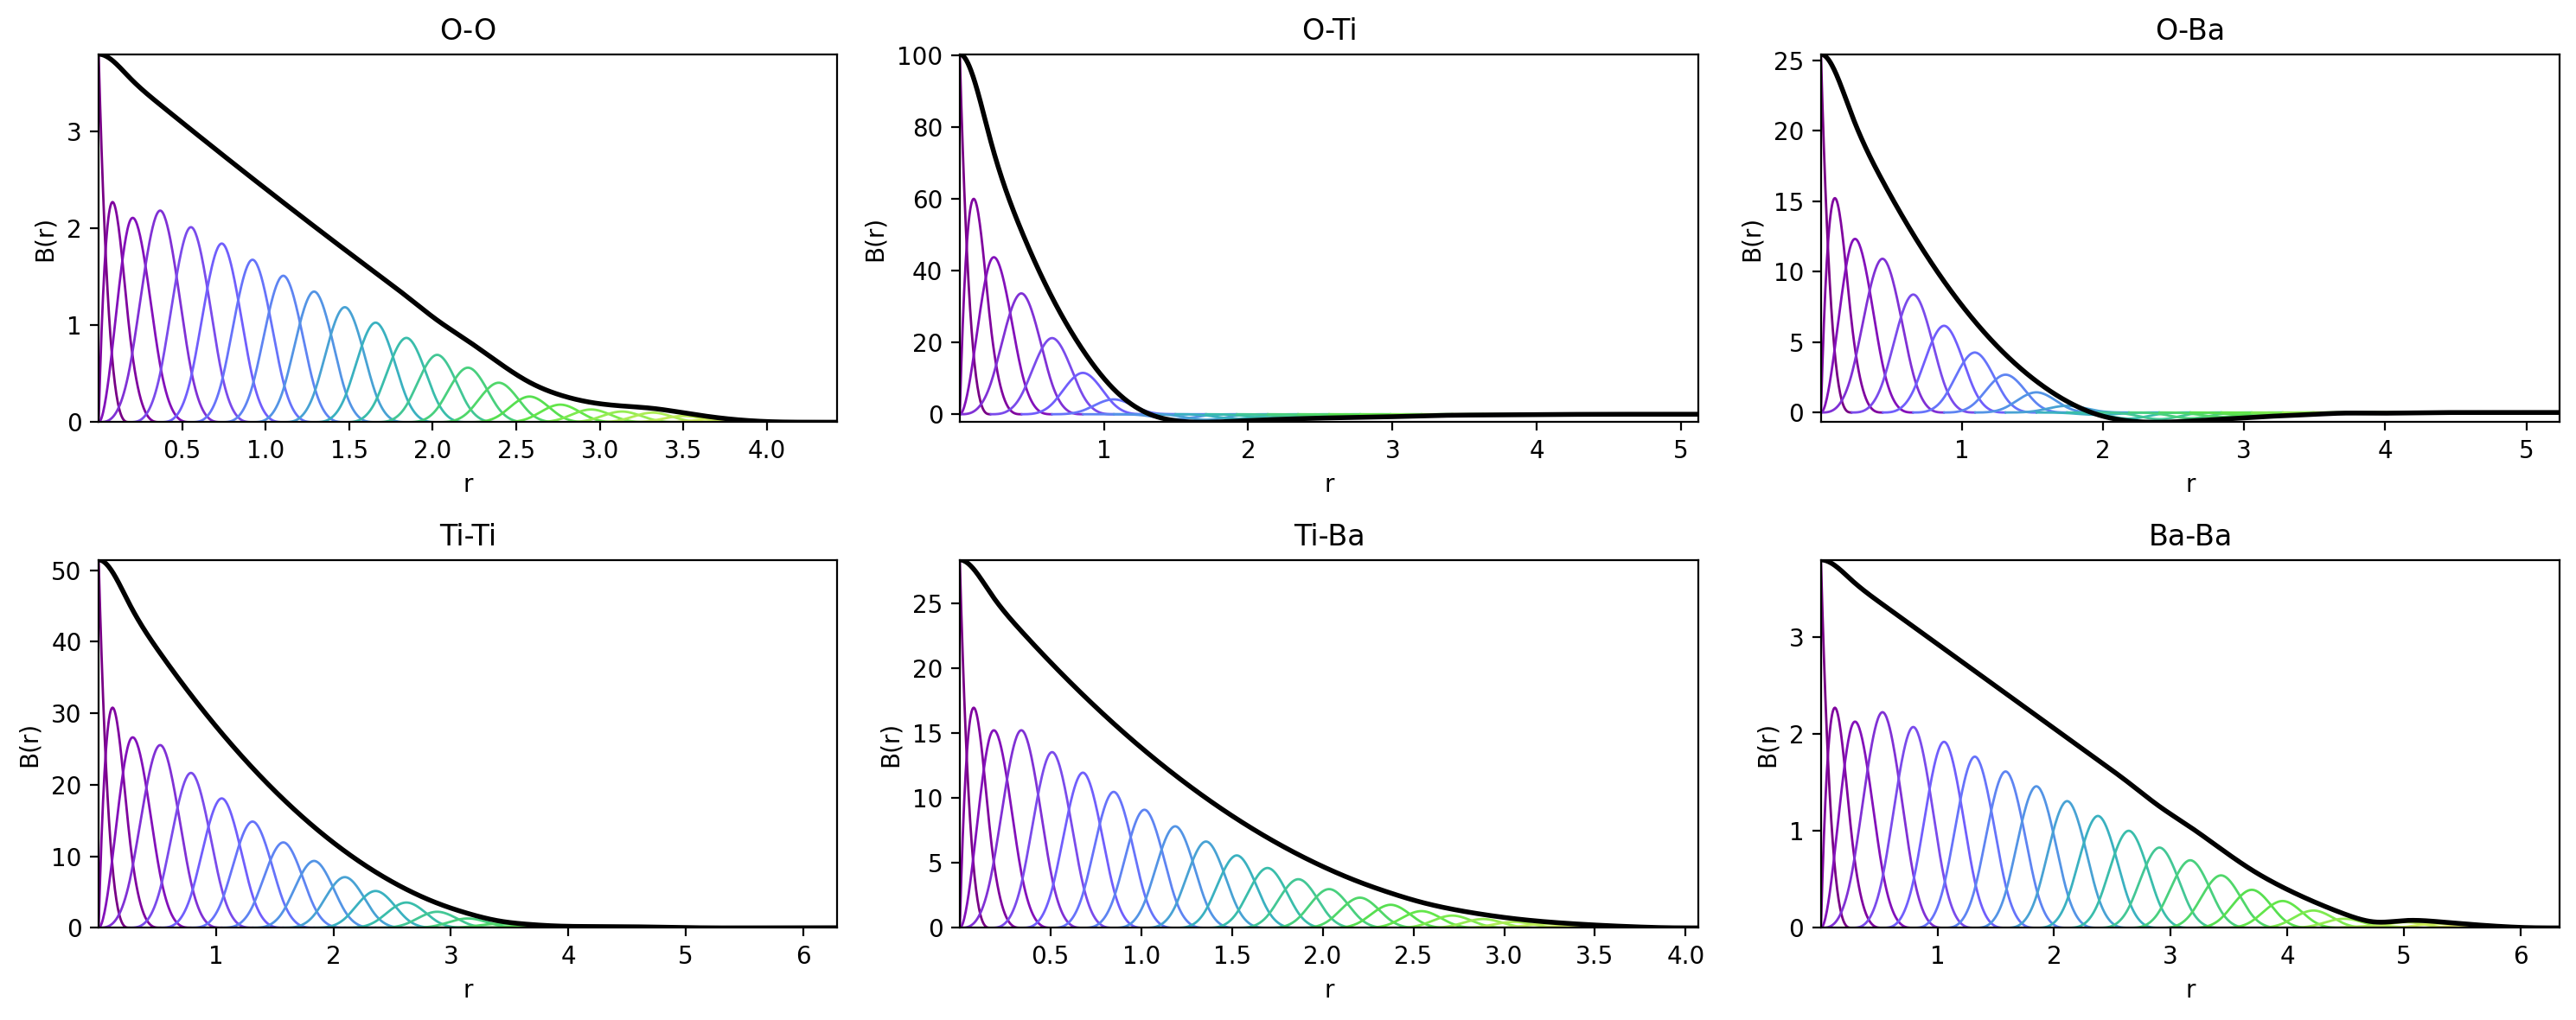

In [79]:
solutions = least_squares.arrange_coefficients(model.coefficients,
                                               bspline_config)
fig, axes = plt.subplots(2, 3, figsize=(15, 6), dpi=200)
for j, interaction in enumerate(bspline_config.interactions_map[2]):
    coefficients = solutions[interaction]
    knot_sequence = bspline_config.knots_map[interaction]
    if j<3:
        plotting.visualize_splines(coefficients, 
                               knot_sequence, 
                               ax=axes[0][j])
        axes[0][j].set_title("-".join(interaction))
    else:
        plotting.visualize_splines(coefficients, 
                               knot_sequence, 
                               ax=axes[1][j-3])
        axes[1][j-3].set_title("-".join(interaction))

fig.tight_layout()


# Predicciones y evaluación del modelo

Predicción con el 30% restante del conjunto de datos (438 estructuras)

In [80]:
training_keys = df_data.index[training_set]
holdout_keys = df_data.index.difference(training_keys)
df_holdout = df_features.loc[holdout_keys]

In [81]:
df_holdout = df_features.loc[holdout_keys]
x_e, y_e, x_f, y_f = least_squares.dataframe_to_tuples(df_holdout,
                                                       n_elements=n_elements,
                                                       energy_key="energy")

In [82]:
p_e = model.predict(x_e)
p_f = model.predict(x_f)

In [83]:
rmse_e = np.sqrt(np.mean(np.subtract(y_e, p_e)**2))
rmse_f = np.sqrt(np.mean(np.subtract(y_f, p_f)**2))
print(f"RMSE: {1000 * rmse_e:.2f} meV/atom")
print(f"RMSF: {1000 * rmse_f:.2f} meV/angstrom")

RMSE: 3.87 meV/atom
RMSF: 134.50 meV/angstrom


### Visualización de las predicciones realizadas por el modelo

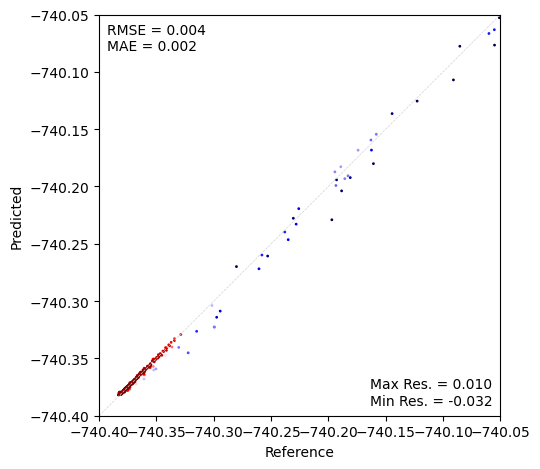

In [84]:
plotting.density_scatter(y_e, p_e, cmap='seismic')
plt.tight_layout()

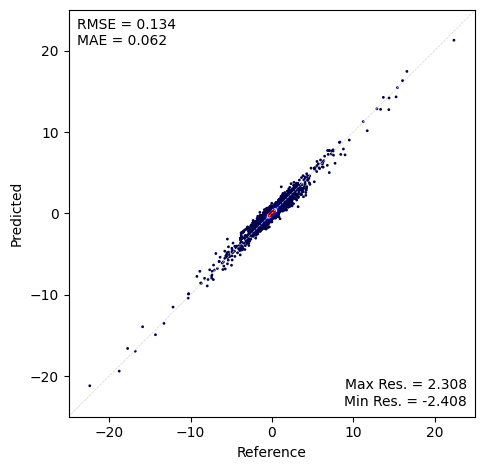

In [85]:
plotting.density_scatter(y_f, p_f, cmap='seismic')
plt.tight_layout()

# Modelo desde/hacia un diccionario

In [86]:
dump = model.as_dict()

In [87]:
model_copy = least_squares.WeightedLinearModel.from_dict(dump)

In [88]:
assert np.allclose(model_copy.coefficients, model.coefficients)

# Guardar modelo en un archivo

In [89]:
filename = "model_2.json"
model.to_json(DATA_OUT_PATH / filename)

# Exportar potencial y potencial tabulado

In [90]:
table_list = []
pair_list = chemical_system.interactions_map[2]
for pair in pair_list:
    text = lammps.export_tabulated_potential(representation.knots_map[pair],
                                             solutions[pair],
                                             pair,
                                             grid=1000,
                                             filename=None)
    table_list.append(text)
combined_text = "\n\n\n".join(table_list)
table_name = DATA_OUT_PATH / "BTO.table"
with open(table_name, "w") as f:
    f.write(combined_text)

# Extra: curva de dispersión de fonones

In [91]:
import ase
from ase import Atom
a = 4
d = a/2
estruct = ase.Atoms([Atom('Ba',(0,0,0)), Atom('Ti',(d,d,d)), Atom('O',(d,d,0)), Atom('O',(0,d,d)),Atom('O',(d,0,d))],cell=[a,a,a],pbc=True)

In [92]:
from scipy.constants import c
def Thz_cm(f):
    """Función para convertir THz a cm^-1"""
    f *= 1e10/c
    return f 

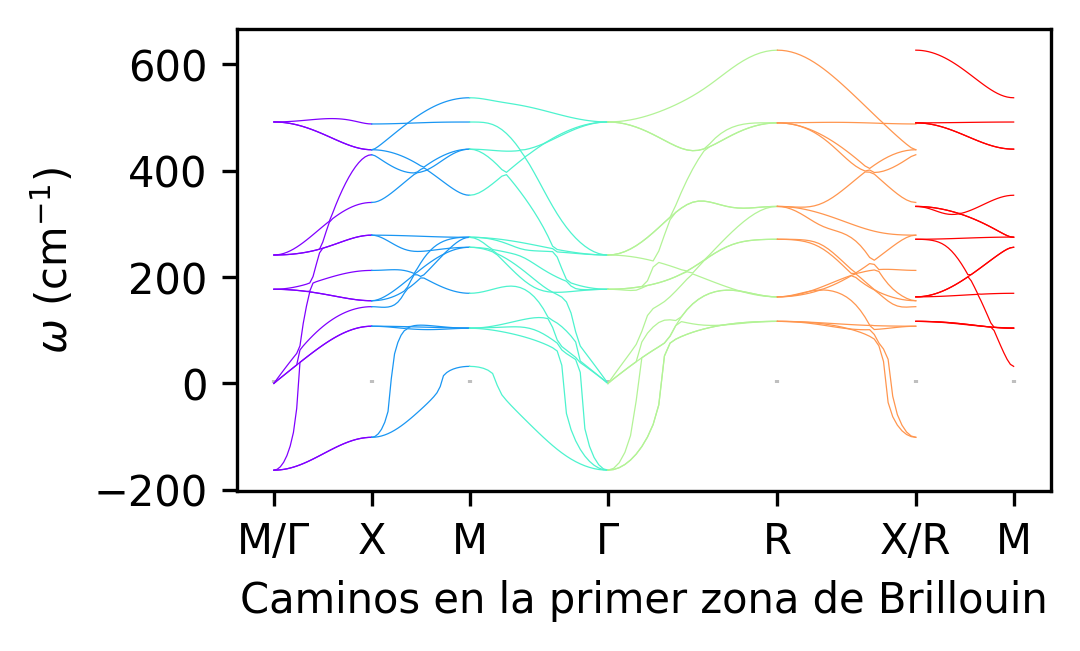

In [93]:
calc = calculator.UFCalculator(model)
force_constants, path_data, bands_dict = calc.get_phonon_data(atoms=estruct, n_super=3, disp=0.05)
for i in range(len(bands_dict['frequencies'])):
    bands_dict['frequencies'][i] = Thz_cm(bands_dict['frequencies'][i])
fig_ax=phonon.plot_phonon_spectrum(path_data=path_data,bands_dict=bands_dict, lw=0.3)
plt.ylabel('$\omega$ (cm$^{-1}$)')
plt.xlabel('Caminos en la primer zona de Brillouin')
plt.show()